# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def data_prep(data):
    display(data.head())
    data.info()
    display(data.duplicated().sum())
    display(data[['f0', 'f1', 'f2', 'product']].describe())
    sns.heatmap(data.corr())
    display(data.corr())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


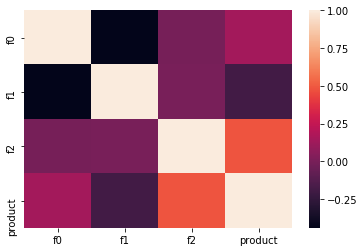

In [4]:
data_prep(geo_data_0)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


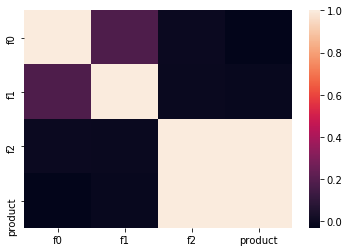

In [5]:
data_prep(geo_data_1)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


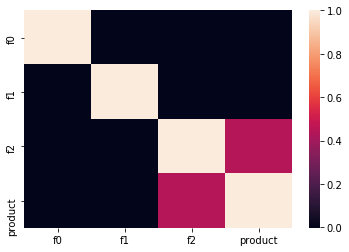

In [6]:
data_prep(geo_data_2)

### Вывод

Датасеты без каких-либо косяков - нет пропусков, дубликатов и лишних столбцов. Можно приступать к обучению моделей.

## Обучение и проверка модели

In [7]:
def features_target(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    return features, target

In [8]:
features_0,target_0 = features_target(geo_data_0)
features_1,target_1 = features_target(geo_data_1)
features_2,target_2 = features_target(geo_data_2)

In [9]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0,
                                                            target_0, test_size = 0.25, random_state = 1312)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1,
                                                            target_1, test_size = 0.25, random_state = 1312)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2,
                                                            target_2, test_size = 0.25, random_state = 1312)
print(features_train_0.shape, features_valid_0.shape)
print(features_train_1.shape, features_valid_1.shape)
print(features_train_2.shape, features_valid_2.shape)

(75000, 3) (25000, 3)
(75000, 3) (25000, 3)
(75000, 3) (25000, 3)


In [10]:
def scaler(features_train, features_valid):
    scal = StandardScaler()
    scal.fit(features_train)
    train = scal.transform(features_train)
    valid = scal.transform(features_valid)
    return train, valid

In [11]:
features_train_0, features_valid_0 = scaler(features_train_0, features_valid_0)
features_train_1, features_valid_1 = scaler(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scaler(features_train_2, features_valid_2)

In [12]:
def metrics(target_valid, predictions):
    rmse = mean_squared_error(target_valid, predictions)**0.5
    predictions_mean = predictions.mean()
    return rmse, predictions_mean

In [13]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
predictions_valid_0 = model_0.predict(features_valid_0)
rmse_0, pred_mean_0 = metrics(target_valid_0, predictions_valid_0)
print('Предсказания региона 1')
print('RMSE =', round(rmse_0,4))
print('Средний предсказанный объём скважины =', round(pred_mean_0,4))

Предсказания региона 1
RMSE = 37.7846
Средний предсказанный объём скважины = 92.7088


In [14]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predictions_valid_1 = model_1.predict(features_valid_1)
rmse_1, pred_mean_1 = metrics(target_valid_1, predictions_valid_1)
print('Предсказания региона 2')
print('RMSE =', round(rmse_1,4))
print('Средний предсказанный объём скважины =', round(pred_mean_1,4))

Предсказания региона 2
RMSE = 0.89
Средний предсказанный объём скважины = 69.1283


In [15]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predictions_valid_2 = model_2.predict(features_valid_2)
rmse_2, pred_mean_2 = metrics(target_valid_2, predictions_valid_2)
print('Предсказания региона 3')
print('RMSE =', round(rmse_2,4))
print('Средний предсказанный объём скважины =', round(pred_mean_2,4))

Предсказания региона 3
RMSE = 39.8976
Средний предсказанный объём скважины = 95.0945


### Вывод

- Мы разделили выборки на тренировочную и валидационную;
- Маcштабировали признаки;
- Обучили 3 модели по трём выборкам;
- Наименьший корень среднеквадратичной ошибки имеет модель обученная по выборке второго региона;
- Наибольший предсказанный средний объём запасов в скважине в 3 регионе.

## Подготовка к расчёту прибыли

In [16]:
geo_pred_0 = pd.DataFrame(predictions_valid_0)
geo_pred_0.index = target_valid_0.index
geo_pred_0 = geo_pred_0.join(target_valid_0)
geo_pred_0 = geo_pred_0.rename(columns = {0:'predict', 'product':'target'})
display(geo_pred_0)

geo_pred_1 = pd.DataFrame(predictions_valid_1)
geo_pred_1.index = target_valid_1.index
geo_pred_1 = geo_pred_1.join(target_valid_1)
geo_pred_1 = geo_pred_1.rename(columns = {0:'predict', 'product':'target'})
display(geo_pred_1)

geo_pred_2 = pd.DataFrame(predictions_valid_2)
geo_pred_2.index = target_valid_2.index
geo_pred_2 = geo_pred_2.join(target_valid_2)
geo_pred_2 = geo_pred_2.rename(columns = {0:'predict', 'product':'target'})
display(geo_pred_2)

,predict,target
61626,63.956616,68.210272
30537,86.738399,63.655643
79627,94.465927,126.623879
9899,89.648227,19.152792
28523,119.799949,80.895442
...,...,...
87925,72.737603,73.788855
78170,100.606348,144.389600
26915,92.185094,80.486146
61847,98.062668,162.053682


,predict,target
61626,30.203601,30.132364
30537,109.429651,107.813044
79627,82.367775,80.859783
9899,82.164152,84.038886
28523,109.089813,107.813044
...,...,...
87925,110.018283,110.992147
78170,135.084566,134.766305
26915,3.377877,3.179103
61847,110.491492,110.992147


,predict,target
61626,118.514373,44.139315
30537,91.327896,62.752216
79627,104.492472,99.157841
9899,123.824065,136.427308
28523,57.670889,34.194256
...,...,...
87925,93.727847,60.900291
78170,100.821042,8.215734
26915,127.453823,161.284688
61847,118.906749,102.380426


In [17]:
budget = 10000000000
price = 450000

breakeven = budget / price / 200
print('Средний объём скважины для безубыточности =', round(breakeven, 4), 'тыс. баррелей')

Средний объём скважины для безубыточности = 111.1111 тыс. баррелей


In [18]:
delta_0 = (1 - pred_mean_0 / breakeven)
delta_1 = (1 - pred_mean_1 / breakeven)
delta_2 = (1 - pred_mean_2 / breakeven)

print('Средний объём скважины в 1 регионе меньше на {:.4f} тыс. баррелей  или на {:.2%}'.format(breakeven - pred_mean_0, delta_0))
print('Средний объём скважины в 2 регионе меньше на {:.4f} тыс. баррелей  или на {:.2%}'.format(breakeven - pred_mean_1, delta_1))
print('Средний объём скважины в 3 регионе меньше на {:.4f} тыс. баррелей  или на {:.2%}'.format(breakeven - pred_mean_2, delta_2))

Средний объём скважины в 1 регионе меньше на 18.4023 тыс. баррелей  или на 16.56%
Средний объём скважины в 2 регионе меньше на 41.9828 тыс. баррелей  или на 37.78%
Средний объём скважины в 3 регионе меньше на 16.0166 тыс. баррелей  или на 14.41%


### Вывод

- Средний объём скважины для безубыточности = 111.1111 тыс. баррелей;
- Во всех трёх регионах средний объём скважины меньше уровня безубыточности.

## Расчёт прибыли и рисков 

In [19]:
def profit(data):
    data = data.sort_values(by='predict', ascending=False).head(200)
    pred = data.predict
    targ = data.target[pred.index]
    pred_profit = (pred.sum() * price - budget) / 1000000000
    target_profit = (targ.sum() * price - budget) / 1000000000
    print('Предсказанная суммарная прибыль по 200 лучших скважин = {:.4f} млрд. руб.'.format(pred_profit))
    print('Фактическая суммарная прибыль по 200 лучших скважин = {:.4f} млрд. руб.'.format(target_profit))

In [20]:
print('Регион 1')
profit(geo_pred_0)

Регион 1
Предсказанная суммарная прибыль по 200 лучших скважин = 3.8938 млрд. руб.
Фактическая суммарная прибыль по 200 лучших скважин = 3.2368 млрд. руб.


In [21]:
print('Регион 2')
profit(geo_pred_1)

Регион 2
Предсказанная суммарная прибыль по 200 лучших скважин = 2.4868 млрд. руб.
Фактическая суммарная прибыль по 200 лучших скважин = 2.4151 млрд. руб.


In [22]:
print('Регион 3')
profit(geo_pred_2)

Регион 3
Предсказанная суммарная прибыль по 200 лучших скважин = 3.3801 млрд. руб.
Фактическая суммарная прибыль по 200 лучших скважин = 2.7636 млрд. руб.


Рассчитали предсказанную и фактическую прибыли по 200 лучших скважин в регионах.

Наибольшая прибыль в 1 регионе.

In [23]:
state = np.random.RandomState(1312)

def profit_for_boots(predictions, target):
    pred_sort = predictions.sort_values(ascending = False)
    targ = target[pred_sort.index].head(200)
    targ_profit = (targ.sum() * price - budget)
    return targ_profit

def bootstrap(data, N):
    pred = data.predict
    targ = data.target
    
    values = []
    
    for i in range(1000):
        target_sample = targ.sample(n = N, replace = True, random_state = state)
        pred_sample = pred[target_sample.index]
        values.append(profit_for_boots(pred_sample, target_sample))
        
    values = pd.Series(values)
    lower_quantile = values.quantile(.025)
    upper_quantile = values.quantile(.975)

    mean = values.mean() / 1000000000
    print('Средняя прибыль = {:.4f} млрд. руб.'.format(mean))
    print('95%-ый доверительный интервал от {:.4f} до {:.4f} млрд. руб.'.format((lower_quantile/1000000000), (upper_quantile/1000000000)))
    return values

Регион 1
Средняя прибыль = 0.4619 млрд. руб.
95%-ый доверительный интервал от -0.0495 до 0.9859 млрд. руб.


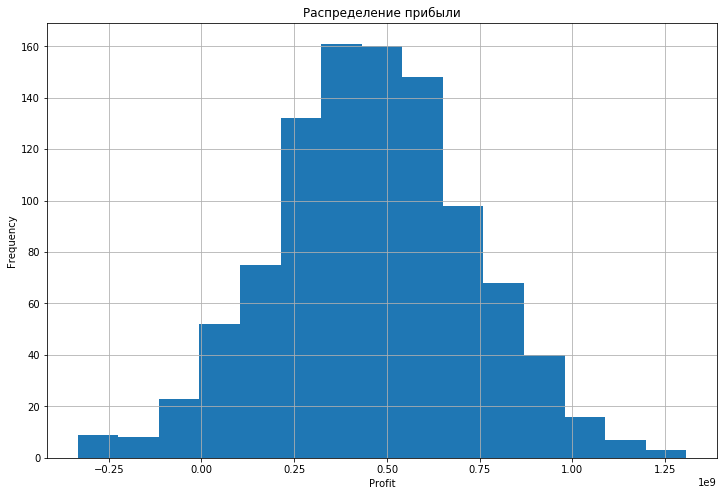

In [24]:
print('Регион 1')
values_0 = bootstrap(geo_pred_0, 500)
plt.figure(figsize = (12, 8))
values_0.plot(kind='hist', grid=True, bins=15)
plt.xlabel('Profit')
plt.title('Распределение прибыли')
plt.show()

In [25]:
print('Риск получить убыток = {:.2%}'.format(values_0[values_0 < 0].shape[0] / values_0.shape[0]))

Риск получить убыток = 4.20%


Регион 2
Средняя прибыль = 0.4972 млрд. руб.
95%-ый доверительный интервал от 0.0481 до 0.9288 млрд. руб.


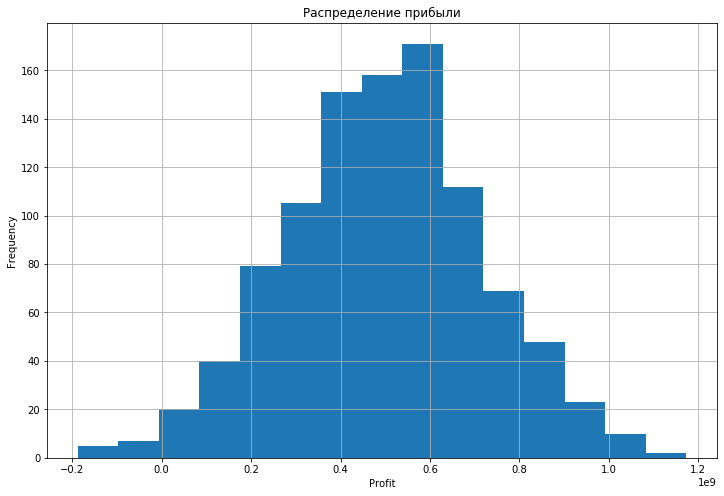

In [26]:
print('Регион 2')
values_1 = bootstrap(geo_pred_1, 500)
plt.figure(figsize = (12, 8))
values_1.plot(kind='hist', grid=True, bins=15)
plt.xlabel('Profit')
plt.title('Распределение прибыли')
plt.show()

In [27]:
print('Риск получить убыток = {:.2%}'.format(values_1[values_1 < 0].shape[0] / values_1.shape[0]))

Риск получить убыток = 1.30%


Регион 3
Средняя прибыль = 0.4202 млрд. руб.
95%-ый доверительный интервал от -0.1149 до 0.9584 млрд. руб.


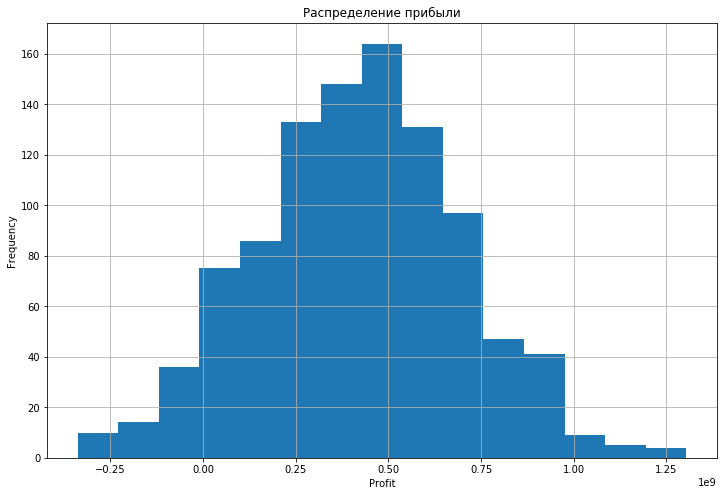

In [28]:
print('Регион 3')
values_2 = bootstrap(geo_pred_2, 500)
plt.figure(figsize = (12, 8))
values_2.plot(kind='hist', grid=True, bins=15)
plt.xlabel('Profit')
plt.title('Распределение прибыли')
plt.show()

In [29]:
print('Риск получить убыток = {:.2%}'.format(values_2[values_2 < 0].shape[0] / values_2.shape[0]))

Риск получить убыток = 6.40%


- Мы рассчитали среднюю прибыль по 200 лучшим предсказанным скважинам;
- Оценили риск возможных убытков (отсутсвия прибыли)
- Наиболее подходящим регионом для бурения скважин является 2 регион, так как в нём наибольшая возможна средняя прибыль (0.4972 млрд. руб.) и наименьший риск получения убытков (1.30%)

## Результаты работы

- Мы разделили выборки на тренировочную и валидационную;
- Маcштабировали признаки;
- Обучили 3 модели по трём выборкам;

**Результаты:**
- Наименьший корень среднеквадратичной ошибки имеет модель обученная по выборке второго региона;
- Наибольший предсказанный средний объём запасов в скважине в 3 регионе.
- Средний объём скважины для безубыточности = 111.1111 тыс. баррелей;
- Во всех трёх регионах средний объём скважины меньше уровня безубыточности.
- Рассчитали среднюю прибыль по 200 лучшим предсказанным скважинам в каждом регионе: 0.4619, 0.4972, 0.4202 млрд. руб. соответственно;
- Оценили риск возможных убытков (отсутсвия прибыли): 4.20%, 1.30%, 6.40% соответственно;

**Вывод**


Наиболее подходящим регионом для бурения скважин является **2 регион**, так как в нём наибольшая возможна средняя прибыль (*0.4972 млрд. руб.*) и наименьший риск получения убытков (*1.30%*).